In [9]:
from PIL import Image, ImageColor
from tqdm import tqdm
import os
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.exc import IntegrityError

from repalette.constants import RGB_IMAGES_DIR, DEFAULT_RGB_DATABASE
from repalette.db.rgb import RGBImage, RGBBase
from repalette.datasets import RawDataset


BAD_NAMES = [
    "ColorLove1a_150.png", "1_2_MineralTones_julia.png", "BarnTones_150.png", "5_17_2ColorWander_maria_minimal.png",
    "3_8_2ColorCraft_craftplanter.png", "ColorHoliday5_150.png", "8_22_2ColorCreature_KarenMacnab.png",
    "3_31_ColorWander_ana.png"
]


def find_edges(array, edge_size=10):
    """
    Finds repeated white pixels - edges
    """
    edges = []
    for i, idx in enumerate(array):
        for delta in range(1, min(edge_size, len(array) - i)):
            if not array[i + delta] == idx + delta:
                break
            edges.append(idx)
    return edges


def cut_numpy_image(np_image):
    """
    Cuts out the rectangle formed by white edges around the actual image
    """
    np_image = np_image[5:, 5:, :]

    # get all white pixels
    white_x = np.argwhere((np_image.mean(axis=2).mean(axis=1) == 255))
    white_y = np.argwhere((np_image.mean(axis=2).mean(axis=0) == 255))
    
    print(white_y)

    edges_x = find_edges(white_x, 15)
    edge_x = int(min(edges_x)) if edges_x else None

    edges_y = find_edges(white_y, 15)
    edge_y = int(min(edges_y)) if edges_y else None

    if not edge_x and not edge_y:
        return None

    if edge_x:
        np_image = np_image[: int(edge_x), :, :]
    if edge_y:
        np_image = np_image[:, : int(edge_y), :]

    return np_image


def validate_image(np_image):
    if np_image is not None:
        if np.prod(np_image.shape) > 160000:
            return True
        else:
            return False
    else:
        return None


def process_image_info(image, palette):
    np_image = np.array(image)
    np_image = cut_numpy_image(np_image)
    if validate_image(np_image):
        np_palette = np.array(
            [ImageColor.getcolor(color, "RGB") for color in reversed(palette)]
        ).reshape((1, 6, 3))
        return np_image, np_palette
    else:
        return None, None

In [10]:

raw_dataset = RawDataset()

os.makedirs(RGB_IMAGES_DIR, exist_ok=True)

engine = create_engine(DEFAULT_RGB_DATABASE)
Session = sessionmaker(bind=engine)
RGBBase.metadata.create_all(engine)

dropped = 0
bar = tqdm(desc=f"Processing... Dropped: [{dropped}]", total=len(raw_dataset))
for (image, palette), raw_image in raw_dataset:
    if raw_image.name not in BAD_NAMES:
        np_image, np_palette = process_image_info(image, palette)
        if np_image is not None:
            processed_image = Image.fromarray(np_image)

            rgb_image = RGBImage(
                name=raw_image.name,
                url=raw_image.url,
                height=raw_image.height,
                width=raw_image.width,
                np_palette=np_palette,
            )
            
            break

            session = Session()
            try:
                session.add(rgb_image)
                session.commit()
                # save image on disk
                processed_image.save(rgb_image.path, "PNG")

            except IntegrityError:  # image already in the database
                pass

        else:
            dropped += 1
            bar.desc = f"Processing... Dropped: [{dropped}]"
    else:
        dropped += 1
        bar.desc = f"Processing... Dropped: [{dropped}]"

    bar.update(n=1)




Processing... Dropped: [0]:   0%|          | 0/3105 [00:00<?, ?it/s]

[[722]
 [723]
 [724]
 [725]
 [726]
 [727]
 [728]
 [729]
 [730]
 [731]
 [732]
 [733]
 [734]
 [735]
 [736]
 [737]
 [738]
 [739]
 [740]
 [741]]


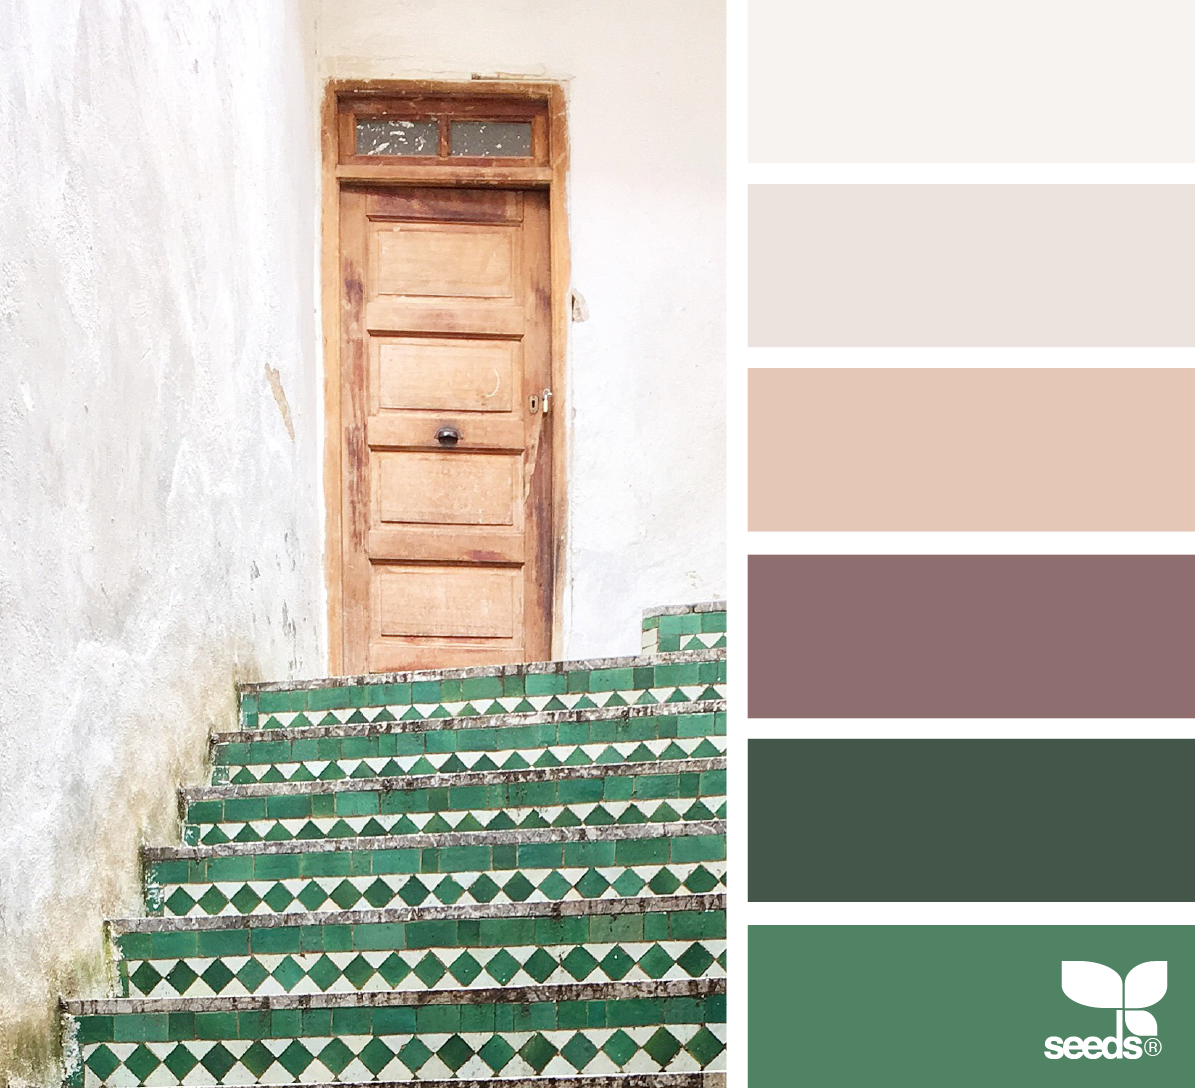

In [4]:
image